# Explore model performances

This document presents an overview of the results from a variety of model outputs, including further modelling chip probabilities.

There are several aspects of the predictions we'd like to explore and compare across models:

- Overall metrics:
     - [ ] Accuracy ([micro-F1](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1): general over-simplified measure of how many chips the model got right
     - [ ] [Kappa score](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c): measure of how many chips the model got right, _above_ what it would have got by pure chance
- Class-based metrics:
     - [ ] Accuracy: proportion of chips the model got right for each class
     - [ ] Macro-F1: overview of how good the model is at predicting each single class
- Confusion matrices: more disaggregated view on predictions. Detailed but not summarising.
- Spatial metrics: compare whether the distribution of predicted labels over space resembles that of the true values
     - [ ] Joint count statistics

In [1]:
import os
import pandas
import geopandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tools_chip_prob_modelling as tools
from copy import deepcopy

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Data

Here we load the original chip geometries, the true labels and predictions from each model and merge everything into a single geo-table.

- Geometries and true labels

In [2]:
gl = geopandas.read_parquet(
    '/home/jovyan/data/model_outputs/db.pq',
    columns=['label', 'train_all', 'geometry']
)

- Model predictions

Grab all files with model predictions

In [3]:
y_preds_f = [
    i for i in os.listdir(
        '/home/jovyan/data/model_outputs/'
    ) if '_y_pred.pq' in i
]
y_preds_f

['HistGradientBoostingClassifier_baseline_wx_y_pred.pq',
 'logite_baseline_wx_y_pred.pq',
 'RandomForestClassifier_baseline_wx_y_pred.pq',
 'HistGradientBoostingClassifier_baseline_y_pred.pq',
 'logite_baseline_y_pred.pq',
 'maxprob_baseline_y_pred.pq',
 'RandomForestClassifier_baseline_y_pred.pq']

Read and store predictions and train/val label

In [4]:
y_preds = pandas.DataFrame(None, index=gl.index)
for f in y_preds_f:
    tab = pandas.read_parquet(
        os.path.join('/home/jovyan/data/model_outputs/', f)
    ).set_index(
        'id'
    ).rename(
        columns=lambda s: f.replace('_y_pred.pq', '')+'_'+s
    )
    y_preds = y_preds.join(tab)

Check train/val indices align across models so we can remove them:

In [5]:
vals = [c for c in y_preds.columns if '_Validation' in c]
for i in range(len(vals)-1):
    print((y_preds[vals[i]] != y_preds[vals[i+1]]).sum())

0
0
0
0
0
0


- Single table

In [6]:
db = gl.join(y_preds.drop(columns=vals))
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 64409 entries, 4 to 103043
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype   
---  ------                                             --------------  -----   
 0   label                                              64409 non-null  category
 1   train_all                                          64409 non-null  bool    
 2   geometry                                           64409 non-null  geometry
 3   HistGradientBoostingClassifier_baseline_wx_y_pred  64409 non-null  object  
 4   logite_baseline_wx_y_pred                          64409 non-null  object  
 5   RandomForestClassifier_baseline_wx_y_pred          64409 non-null  object  
 6   HistGradientBoostingClassifier_baseline_y_pred     64409 non-null  object  
 7   logite_baseline_y_pred                             64409 non-null  object  
 8   maxprob_baseline_y_pred                            64409 non-null  

## Metrics

- Set intuitive order of models

In [7]:
model_names = [
    'maxprob_baseline_y_pred',
    'logite_baseline_y_pred',
    'logite_baseline_wx_y_pred',
    'RandomForestClassifier_baseline_y_pred',
    'RandomForestClassifier_baseline_wx_y_pred',
    'HistGradientBoostingClassifier_baseline_y_pred',
    'HistGradientBoostingClassifier_baseline_wx_y_pred'
]
model_names_short = [
    'maxprob_baseline',
    'logite',
    'logite_wx',
    'RF',
    'RF_wx',
    'HBGB',
    'HBGB_wx'
]

- Calculate all metrics by model

In [8]:
metrics = {}
train = db.query('train_all')
val = db.query('~train_all')
for model in model_names:
    meta = tools.build_perf(
        train['label'],
        train[model],
        val['label'],
        val[model],
        tools.class_names
    )
    metrics[model] = deepcopy(meta)

### Global

- Single scores

In [23]:
global_scores = []
for model in metrics:
    global_scores.append(pandas.Series(
        {i.replace('perf_', '').replace('_val', ''): metrics[model][i] for i in [
            'perf_kappa_val', 
            'perf_model_accuracy_val', 
            'perf_macro_f1_avg_val',
            'perf_macro_f1_w_val'
        ]},
        name=model
    ))
global_scores = pandas.concat(
    global_scores, axis=1
)[
    model_names
].rename(
    columns=lambda s: s.replace('_y_pred', '')
).T
global_scores

,kappa,model_accuracy,macro_f1_avg,macro_f1_w
maxprob_baseline,0.082029,0.240624,0.152201,0.257502
logite_baseline,0.156026,0.418220,0.148086,0.403382
logite_baseline_wx,0.188568,0.426946,0.163392,0.421285
RandomForestClassifier_baseline,0.170676,0.484988,0.169646,0.455800
RandomForestClassifier_baseline_wx,0.260813,0.529699,0.257296,0.504723
HistGradientBoostingClassifier_baseline,0.184691,0.491708,0.217279,0.466327
HistGradientBoostingClassifier_baseline_wx,0.240259,0.507967,0.231894,0.494618


- Confusion matrices

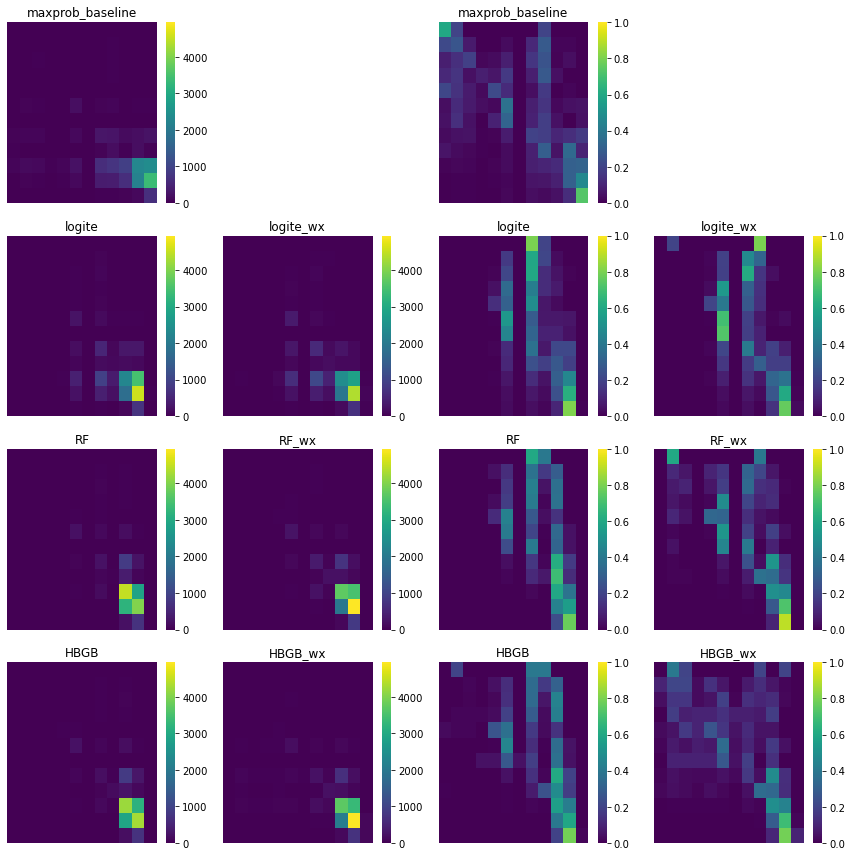

In [20]:
f, axs = plt.subplots(4, 4, figsize=(12, 12))
model_loc = [
    (0, 0), # Maxprob
    (1, 0), # Logite
    (1, 1), # Logite Wx
    (2, 0), # RF
    (2, 1), # RF Wx
    (3, 0), # HGBD
    (3, 1)  # HGBD Wx
]
                    # Raw counts #
maxcount = max([np.array(metrics[model]['perf_confusion_val']).max()])
for i, model in enumerate(model_names):
    ax = tools.build_cm_plot(
        metrics[model]['perf_confusion_val'], 
        maxcount=maxcount,
        ax=axs[model_loc[i]]
    )
    ax.set_title(model_names_short[i])
axs[0, 1].set_axis_off()
                    # Std #
for i, model in enumerate(model_names):
    xy = model_loc[i]
    ax = tools.build_cm_plot(
        metrics[model]['perf_confusion_val'], 
        maxcount=maxcount,
        std=True,
        ax=axs[xy[0], xy[1]+2]
    )
    ax.set_title(model_names_short[i])
axs[0, 3].set_axis_off()
plt.tight_layout()

### Class-based

In [31]:
wca = []
for i, model in enumerate(model_names):
    wca.append(pandas.Series(
        metrics[model]['perf_within_class_accuracy_val'],
        metrics[model]['meta_class_names'],
        name=model_names_short[i]
    ))
wca = pandas.concat(
    wca, axis=1
)[model_names_short].T
wca

,urbanity,dense_urban_neighbourhoods,dense_residential_neighbourhoods,connected_residential_neighbourhoods,gridded_residential_quarters,accessible_suburbia,disconnected_suburbia,open_sprawl,warehouse_park_land,urban_buffer,countryside_agriculture,wild_countryside
maxprob_baseline,0.6,0.263889,0.190476,0.082192,0.223529,0.370526,0.000000,0.195699,0.293907,0.120669,0.303030,0.732816
logite,0.0,0.000000,0.000000,0.000000,0.129412,0.528421,0.000000,0.371326,0.184588,0.300146,0.632074,0.005543
logite_wx,0.0,0.000000,0.000000,0.000000,0.200000,0.698947,0.000000,0.409319,0.297491,0.320324,0.602740,0.025499
RF,0.0,0.000000,0.000000,0.000000,0.117647,0.408421,0.000000,0.156989,0.062724,0.595380,0.554310,0.000000
RF_wx,0.0,0.111111,0.095238,0.000000,0.329412,0.524211,0.000000,0.248746,0.367384,0.493429,0.720631,0.002217
HBGB,0.0,0.000000,0.009524,0.013699,0.258824,0.454737,0.045455,0.136918,0.250896,0.558609,0.592500,0.012195
HBGB_wx,0.0,0.208333,0.152381,0.095890,0.258824,0.345263,0.045455,0.161290,0.349462,0.490774,0.683963,0.097561


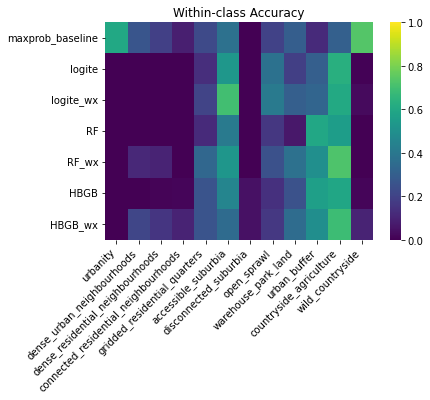

In [36]:
h = sns.heatmap(wca, vmin=0, vmax=1, cmap='viridis')
h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
h.set_title('Within-class Accuracy');

### Spatial

In [25]:
metrics[model_names[0]]['meta_class_names']

['urbanity',
 'dense_urban_neighbourhoods',
 'dense_residential_neighbourhoods',
 'connected_residential_neighbourhoods',
 'gridded_residential_quarters',
 'accessible_suburbia',
 'disconnected_suburbia',
 'open_sprawl',
 'warehouse_park_land',
 'urban_buffer',
 'countryside_agriculture',
 'wild_countryside']

In [115]:
[i for i in list(
    metrics['HistGradientBoostingClassifier_baseline_wx_y_pred'].keys()
) if ('perf_' in i) and ('val' in i) and ('confusion' in i)]

['perf_confusion_val']